In [1]:
import numpy as np
import pandas as pd
import torch 
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn, optim
###look for this
from torchvision import transforms as T, datasets, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm.autonotebook import tqdm

In [2]:
train_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/"
val_loc = "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/"

In [3]:
TRAIN = 'train'
VAL = 'val'

In [4]:
def data_transform(phase = None):
    if phase == TRAIN:
        data_T = T.Compose([
            T.Resize(size = (256,256)),
            T.RandomRotation(degrees = (-20,20)),
            T.CenterCrop(size = 224),
            T.ToTensor(),
            T.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        ])
        
    elif phase == VAL:
        data_T = T.Compose([
            T.Resize(size = (224,224)), 
            T.ToTensor(), 
            T.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        ])
        
    return data_T

In [5]:
trainset = datasets.ImageFolder(train_loc, transform = data_transform(TRAIN))
validset = datasets.ImageFolder(val_loc, transform = data_transform(VAL))

In [6]:
class_name = trainset.classes
print(class_name)
print(trainset.class_to_idx)

['covid', 'normal', 'pneumonia']
{'covid': 0, 'normal': 1, 'pneumonia': 2}


In [7]:
def get_class_count(dataset):
    class_name = dataset.classes
    classes = []
    for _,labels in tqdm(dataset):
        classes.append(class_name[labels])
    return classes

100%|██████████| 17958/17958 [04:07<00:00, 72.57it/s]


Text(0.5, 1.0, 'Train_set')

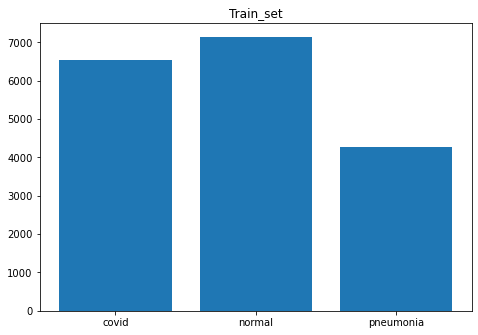

In [11]:
count = get_class_count(trainset)
unique, counts = np.unique(count, return_counts=True)
dict(zip(unique, counts))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts)
ax.set_title("Train_set")

100%|██████████| 3432/3432 [00:51<00:00, 66.82it/s] 


Text(0.5, 1.0, 'valid_set')

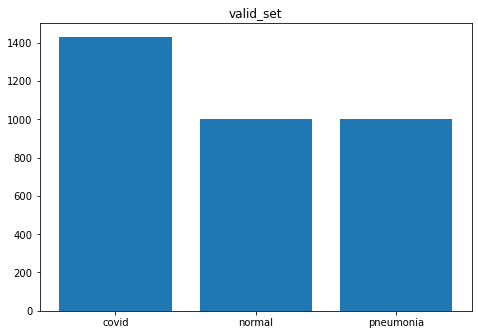

In [12]:
count = get_class_count(validset)
unique, counts = np.unique(count, return_counts=True)
dict(zip(unique, counts))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(unique,counts)
ax.set_title("valid_set")

In [8]:
trainloader = DataLoader(trainset,batch_size = 64,shuffle = True)
validloader = DataLoader(validset,batch_size = 32,shuffle = False)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [10]:
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

for param in resnet50.parameters():
    param.require_grad = True


In [11]:
model = resnet50
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 5)
epochs = 100
valid_loss_min = np.Inf


In [13]:
def accuracy(y_pred,y_true):
    y_pred = torch.exp(y_pred)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


In [14]:
train_loss_hist = []
valid_loss_hist = []
train_acc_hist = []
valid_acc_hist = []


for i in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 
    
    
    model.train()
    
    for images,labels in tqdm(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        ps = model(images)
        loss = criterion(ps,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy(ps,labels)
        train_loss += loss.item()
        
    avg_train_acc = train_acc / len(trainloader)
    train_acc_hist.append(avg_train_acc)
    avg_train_loss = train_loss / len(trainloader)
    train_loss_hist.append(avg_train_loss)
        
    model.eval()
    with torch.no_grad():
        
        for images,labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            ps = model(images)
            loss = criterion(ps,labels)
            
            valid_acc += accuracy(ps,labels)
            valid_loss += loss.item()
            
            
        avg_valid_acc = valid_acc / len(validloader)
        valid_acc_hist.append(avg_valid_acc)
        avg_valid_loss = valid_loss / len(validloader)
        valid_loss_hist.append(avg_valid_loss)
        
        schedular.step(avg_valid_loss)
        
        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'Resnet50_100_epochs.pt')
            
            valid_loss_min = avg_valid_loss
            
            
    print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1,avg_train_loss,avg_train_acc))
    print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1,avg_valid_loss,avg_valid_acc))


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.843162).   Saving model ...
Epoch : 1 Train Loss : 0.519245 Train Acc : 0.800056
Epoch : 1 Valid Loss : 0.843162 Valid Acc : 0.689815


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.843162 --> 0.338233).   Saving model ...
Epoch : 2 Train Loss : 0.366618 Train Acc : 0.869232
Epoch : 2 Valid Loss : 0.338233 Valid Acc : 0.874132


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.304244 Train Acc : 0.892085
Epoch : 3 Valid Loss : 0.472906 Valid Acc : 0.848090


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.338233 --> 0.319234).   Saving model ...
Epoch : 4 Train Loss : 0.282987 Train Acc : 0.900780
Epoch : 4 Valid Loss : 0.319234 Valid Acc : 0.888310


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.319234 --> 0.243953).   Saving model ...
Epoch : 5 Train Loss : 0.263337 Train Acc : 0.907377
Epoch : 5 Valid Loss : 0.243953 Valid Acc : 0.909144


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.252012 Train Acc : 0.910417
Epoch : 6 Valid Loss : 0.297353 Valid Acc : 0.901620


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 7 Train Loss : 0.228516 Train Acc : 0.921928
Epoch : 7 Valid Loss : 0.347946 Valid Acc : 0.872685


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.243953 --> 0.242547).   Saving model ...
Epoch : 8 Train Loss : 0.219615 Train Acc : 0.922592
Epoch : 8 Valid Loss : 0.242547 Valid Acc : 0.914931


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.210916 Train Acc : 0.926841
Epoch : 9 Valid Loss : 0.286161 Valid Acc : 0.898438


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.202774 Train Acc : 0.929639
Epoch : 10 Valid Loss : 0.260181 Valid Acc : 0.904225


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.195725 Train Acc : 0.933362
Epoch : 11 Valid Loss : 1.111157 Valid Acc : 0.681134


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.242547 --> 0.232089).   Saving model ...
Epoch : 12 Train Loss : 0.180426 Train Acc : 0.939145
Epoch : 12 Valid Loss : 0.232089 Valid Acc : 0.919850


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.232089 --> 0.213884).   Saving model ...
Epoch : 13 Train Loss : 0.182211 Train Acc : 0.935551
Epoch : 13 Valid Loss : 0.213884 Valid Acc : 0.928241


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.170645 Train Acc : 0.940371
Epoch : 14 Valid Loss : 0.233380 Valid Acc : 0.916956


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.167869 Train Acc : 0.940298
Epoch : 15 Valid Loss : 0.309209 Valid Acc : 0.899306


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.161180 Train Acc : 0.943336
Epoch : 16 Valid Loss : 0.318072 Valid Acc : 0.894097


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.163025 Train Acc : 0.943037
Epoch : 17 Valid Loss : 0.343796 Valid Acc : 0.880498


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.152389 Train Acc : 0.947749
Epoch : 18 Valid Loss : 0.356904 Valid Acc : 0.888889


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.150660 Train Acc : 0.947395
Epoch : 19 Valid Loss : 0.239553 Valid Acc : 0.918981


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.213884 --> 0.205728).   Saving model ...
Epoch : 20 Train Loss : 0.108783 Train Acc : 0.963652
Epoch : 20 Valid Loss : 0.205728 Valid Acc : 0.934606


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.205728 --> 0.193076).   Saving model ...
Epoch : 21 Train Loss : 0.087772 Train Acc : 0.970807
Epoch : 21 Valid Loss : 0.193076 Valid Acc : 0.940683


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 22 Train Loss : 0.078782 Train Acc : 0.972642
Epoch : 22 Valid Loss : 0.193573 Valid Acc : 0.940683


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 23 Train Loss : 0.073933 Train Acc : 0.975589
Epoch : 23 Valid Loss : 0.195621 Valid Acc : 0.940972


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 24 Train Loss : 0.067658 Train Acc : 0.977998
Epoch : 24 Valid Loss : 0.203555 Valid Acc : 0.941551


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 25 Train Loss : 0.065932 Train Acc : 0.978015
Epoch : 25 Valid Loss : 0.243006 Valid Acc : 0.936921


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Validation loss decreased (0.193076 --> 0.184109).   Saving model ...
Epoch : 26 Train Loss : 0.060808 Train Acc : 0.979815
Epoch : 26 Valid Loss : 0.184109 Valid Acc : 0.947627


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 27 Train Loss : 0.060510 Train Acc : 0.979982
Epoch : 27 Valid Loss : 0.214061 Valid Acc : 0.942998


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 28 Train Loss : 0.059100 Train Acc : 0.979871
Epoch : 28 Valid Loss : 0.214789 Valid Acc : 0.940104


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 29 Train Loss : 0.054478 Train Acc : 0.981779
Epoch : 29 Valid Loss : 0.230864 Valid Acc : 0.940104


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 30 Train Loss : 0.050934 Train Acc : 0.983002
Epoch : 30 Valid Loss : 0.240917 Valid Acc : 0.942130


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 31 Train Loss : 0.047820 Train Acc : 0.983430
Epoch : 31 Valid Loss : 0.257162 Valid Acc : 0.934317


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 32 Train Loss : 0.046208 Train Acc : 0.984431
Epoch : 32 Valid Loss : 0.262587 Valid Acc : 0.938657


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 33 Train Loss : 0.041805 Train Acc : 0.985320
Epoch : 33 Valid Loss : 0.233247 Valid Acc : 0.942130


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 34 Train Loss : 0.039501 Train Acc : 0.986839
Epoch : 34 Valid Loss : 0.239607 Valid Acc : 0.940972


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 35 Train Loss : 0.037997 Train Acc : 0.987433
Epoch : 35 Valid Loss : 0.226682 Valid Acc : 0.945602


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 36 Train Loss : 0.036061 Train Acc : 0.987506
Epoch : 36 Valid Loss : 0.249023 Valid Acc : 0.940683


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 37 Train Loss : 0.035969 Train Acc : 0.988212
Epoch : 37 Valid Loss : 0.225973 Valid Acc : 0.946759


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 38 Train Loss : 0.034465 Train Acc : 0.988285
Epoch : 38 Valid Loss : 0.224105 Valid Acc : 0.947049


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 39 Train Loss : 0.031792 Train Acc : 0.989119
Epoch : 39 Valid Loss : 0.242644 Valid Acc : 0.943866


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 40 Train Loss : 0.033128 Train Acc : 0.988823
Epoch : 40 Valid Loss : 0.237857 Valid Acc : 0.946181


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 41 Train Loss : 0.033968 Train Acc : 0.988768
Epoch : 41 Valid Loss : 0.241731 Valid Acc : 0.943576


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 42 Train Loss : 0.033807 Train Acc : 0.987934
Epoch : 42 Valid Loss : 0.226096 Valid Acc : 0.946181


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 43 Train Loss : 0.034230 Train Acc : 0.988434
Epoch : 43 Valid Loss : 0.252883 Valid Acc : 0.942130


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 44 Train Loss : 0.034254 Train Acc : 0.988007
Epoch : 44 Valid Loss : 0.250163 Valid Acc : 0.944734


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 45 Train Loss : 0.032540 Train Acc : 0.989602
Epoch : 45 Valid Loss : 0.231376 Valid Acc : 0.946470


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 46 Train Loss : 0.032892 Train Acc : 0.989268
Epoch : 46 Valid Loss : 0.238647 Valid Acc : 0.943866


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 47 Train Loss : 0.035879 Train Acc : 0.988285
Epoch : 47 Valid Loss : 0.245536 Valid Acc : 0.942419


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 48 Train Loss : 0.034428 Train Acc : 0.988712
Epoch : 48 Valid Loss : 0.241131 Valid Acc : 0.944155


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 49 Train Loss : 0.033165 Train Acc : 0.988823
Epoch : 49 Valid Loss : 0.258466 Valid Acc : 0.939815


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 50 Train Loss : 0.035825 Train Acc : 0.987618
Epoch : 50 Valid Loss : 0.248633 Valid Acc : 0.942708


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 51 Train Loss : 0.036646 Train Acc : 0.987618
Epoch : 51 Valid Loss : 0.229023 Valid Acc : 0.946181


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 52 Train Loss : 0.032150 Train Acc : 0.989675
Epoch : 52 Valid Loss : 0.232727 Valid Acc : 0.945602


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 53 Train Loss : 0.033191 Train Acc : 0.989101
Epoch : 53 Valid Loss : 0.238560 Valid Acc : 0.945023


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 54 Train Loss : 0.034021 Train Acc : 0.988490
Epoch : 54 Valid Loss : 0.234793 Valid Acc : 0.945312


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 55 Train Loss : 0.033730 Train Acc : 0.988935
Epoch : 55 Valid Loss : 0.241475 Valid Acc : 0.943287


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 56 Train Loss : 0.035337 Train Acc : 0.988601
Epoch : 56 Valid Loss : 0.233199 Valid Acc : 0.945891


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 57 Train Loss : 0.037868 Train Acc : 0.987395
Epoch : 57 Valid Loss : 0.250902 Valid Acc : 0.942130


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 58 Train Loss : 0.032752 Train Acc : 0.988785
Epoch : 58 Valid Loss : 0.238167 Valid Acc : 0.947049


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 59 Train Loss : 0.036129 Train Acc : 0.988101
Epoch : 59 Valid Loss : 0.252469 Valid Acc : 0.941262


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 60 Train Loss : 0.032939 Train Acc : 0.988156
Epoch : 60 Valid Loss : 0.245542 Valid Acc : 0.943287


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 61 Train Loss : 0.035869 Train Acc : 0.988101
Epoch : 61 Valid Loss : 0.217693 Valid Acc : 0.948785


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 62 Train Loss : 0.032520 Train Acc : 0.989268
Epoch : 62 Valid Loss : 0.239599 Valid Acc : 0.944155


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 63 Train Loss : 0.033894 Train Acc : 0.989046
Epoch : 63 Valid Loss : 0.234300 Valid Acc : 0.944444


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 64 Train Loss : 0.034405 Train Acc : 0.988490
Epoch : 64 Valid Loss : 0.247019 Valid Acc : 0.942419


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 65 Train Loss : 0.034245 Train Acc : 0.988935
Epoch : 65 Valid Loss : 0.241353 Valid Acc : 0.945023


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 66 Train Loss : 0.034530 Train Acc : 0.988452
Epoch : 66 Valid Loss : 0.233070 Valid Acc : 0.946759


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 67 Train Loss : 0.034390 Train Acc : 0.989379
Epoch : 67 Valid Loss : 0.234319 Valid Acc : 0.946181


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 68 Train Loss : 0.032302 Train Acc : 0.989675
Epoch : 68 Valid Loss : 0.239832 Valid Acc : 0.945602


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 69 Train Loss : 0.032997 Train Acc : 0.988990
Epoch : 69 Valid Loss : 0.233457 Valid Acc : 0.946759


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 70 Train Loss : 0.032583 Train Acc : 0.989435
Epoch : 70 Valid Loss : 0.236587 Valid Acc : 0.944734


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 71 Train Loss : 0.033537 Train Acc : 0.988768
Epoch : 71 Valid Loss : 0.233873 Valid Acc : 0.945602


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 72 Train Loss : 0.036393 Train Acc : 0.987896
Epoch : 72 Valid Loss : 0.245374 Valid Acc : 0.941840


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 73 Train Loss : 0.036051 Train Acc : 0.987951
Epoch : 73 Valid Loss : 0.222163 Valid Acc : 0.947049


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 74 Train Loss : 0.033432 Train Acc : 0.988490
Epoch : 74 Valid Loss : 0.249294 Valid Acc : 0.942130


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 75 Train Loss : 0.036168 Train Acc : 0.987656
Epoch : 75 Valid Loss : 0.232379 Valid Acc : 0.945602


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 76 Train Loss : 0.032617 Train Acc : 0.988990
Epoch : 76 Valid Loss : 0.243523 Valid Acc : 0.942708


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 77 Train Loss : 0.033673 Train Acc : 0.988601
Epoch : 77 Valid Loss : 0.238693 Valid Acc : 0.942998


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 78 Train Loss : 0.033459 Train Acc : 0.988376
Epoch : 78 Valid Loss : 0.244463 Valid Acc : 0.944155


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 79 Train Loss : 0.035186 Train Acc : 0.988341
Epoch : 79 Valid Loss : 0.248137 Valid Acc : 0.942708


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 80 Train Loss : 0.033406 Train Acc : 0.988768
Epoch : 80 Valid Loss : 0.241387 Valid Acc : 0.943287


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 81 Train Loss : 0.033529 Train Acc : 0.989063
Epoch : 81 Valid Loss : 0.242411 Valid Acc : 0.944734


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 82 Train Loss : 0.032397 Train Acc : 0.989175
Epoch : 82 Valid Loss : 0.240675 Valid Acc : 0.945312


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 83 Train Loss : 0.035287 Train Acc : 0.987284
Epoch : 83 Valid Loss : 0.259259 Valid Acc : 0.938947


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 84 Train Loss : 0.035679 Train Acc : 0.988507
Epoch : 84 Valid Loss : 0.229640 Valid Acc : 0.947627


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 85 Train Loss : 0.032207 Train Acc : 0.989824
Epoch : 85 Valid Loss : 0.241140 Valid Acc : 0.944734


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 86 Train Loss : 0.033529 Train Acc : 0.989936
Epoch : 86 Valid Loss : 0.232901 Valid Acc : 0.945602


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 87 Train Loss : 0.035447 Train Acc : 0.987190
Epoch : 87 Valid Loss : 0.243857 Valid Acc : 0.944155


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 88 Train Loss : 0.037250 Train Acc : 0.987691
Epoch : 88 Valid Loss : 0.239040 Valid Acc : 0.944444


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 89 Train Loss : 0.035120 Train Acc : 0.989008
Epoch : 89 Valid Loss : 0.247322 Valid Acc : 0.942130


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 90 Train Loss : 0.036922 Train Acc : 0.987100
Epoch : 90 Valid Loss : 0.243206 Valid Acc : 0.943866


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 91 Train Loss : 0.032458 Train Acc : 0.989435
Epoch : 91 Valid Loss : 0.242666 Valid Acc : 0.941840


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 92 Train Loss : 0.033435 Train Acc : 0.988247
Epoch : 92 Valid Loss : 0.239882 Valid Acc : 0.947338


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 93 Train Loss : 0.033542 Train Acc : 0.988935
Epoch : 93 Valid Loss : 0.238976 Valid Acc : 0.944444


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 94 Train Loss : 0.032280 Train Acc : 0.989046
Epoch : 94 Valid Loss : 0.243596 Valid Acc : 0.944155


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 95 Train Loss : 0.033247 Train Acc : 0.988545
Epoch : 95 Valid Loss : 0.225975 Valid Acc : 0.947627


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 96 Train Loss : 0.035338 Train Acc : 0.987951
Epoch : 96 Valid Loss : 0.236197 Valid Acc : 0.945023


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 97 Train Loss : 0.032839 Train Acc : 0.989842
Epoch : 97 Valid Loss : 0.235328 Valid Acc : 0.945602


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 98 Train Loss : 0.034526 Train Acc : 0.988358
Epoch : 98 Valid Loss : 0.226930 Valid Acc : 0.947627


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 99 Train Loss : 0.034783 Train Acc : 0.988935
Epoch : 99 Valid Loss : 0.237182 Valid Acc : 0.945023


  0%|          | 0/281 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch : 100 Train Loss : 0.034298 Train Acc : 0.988434
Epoch : 100 Valid Loss : 0.254183 Valid Acc : 0.941262


Text(0, 0.5, 'Accuracy')

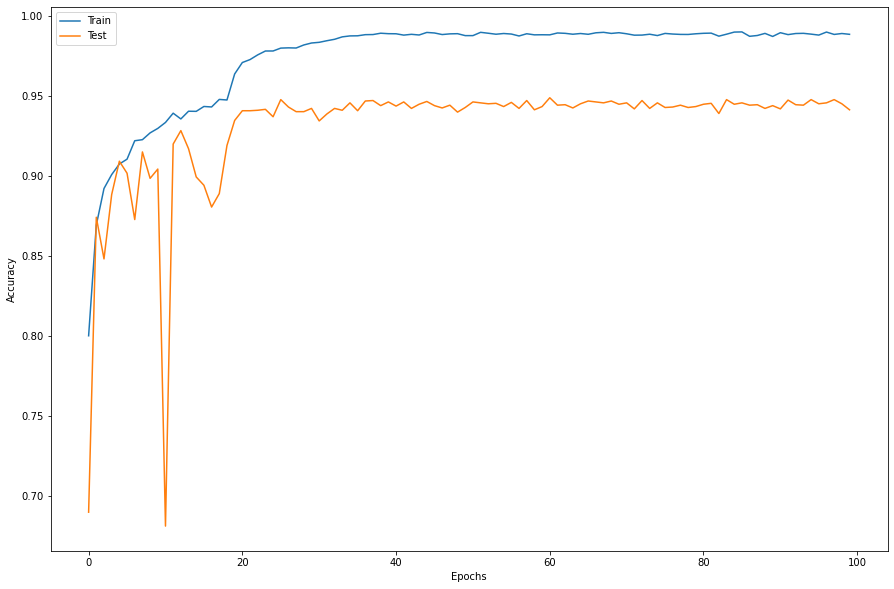

In [23]:
plt.figure(figsize=(15,10))
plt.plot(train_acc_hist, label = 'Train')
plt.plot(valid_acc_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

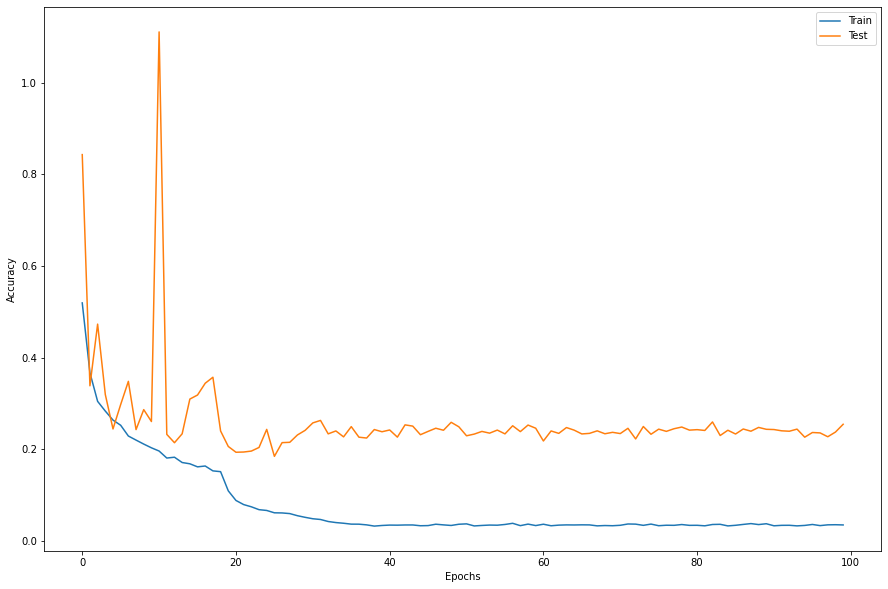

In [24]:
plt.figure(figsize=(15,10))
plt.plot(train_loss_hist, label = 'Train')
plt.plot(valid_loss_hist, label = 'Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

### Inference on Validation set of the best model

In [12]:
saved_model = torch.load("./baseline_2_model.pt")

In [14]:
model.load_state_dict(saved_model['model_state_dict'])

<All keys matched successfully>

In [22]:
model.eval()

test_loss = 0
test_acc = 0

for images,labels in tqdm(validloader):
    
    images = images.to(device)
    labels = labels.to(device)
    
    pred = model(images)
#     loss = criterion(pred,labels)
    
#     test_loss += loss.item()
    test_acc += accuracy(pred,labels)
    
# avg_test_loss = test_loss/len(validloader)
avg_test_acc = test_acc/len(validloader)


  0%|          | 0/429 [00:00<?, ?it/s]

In [31]:
print(f"Accuracy: {avg_test_acc.item()*100} %%!")

Accuracy: 91.08391404151917 %%!


#### Confusion Matrix

In [26]:
import seaborn as sns

In [27]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in tqdm(enumerate(validloader)):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

0it [00:00, ?it/s]

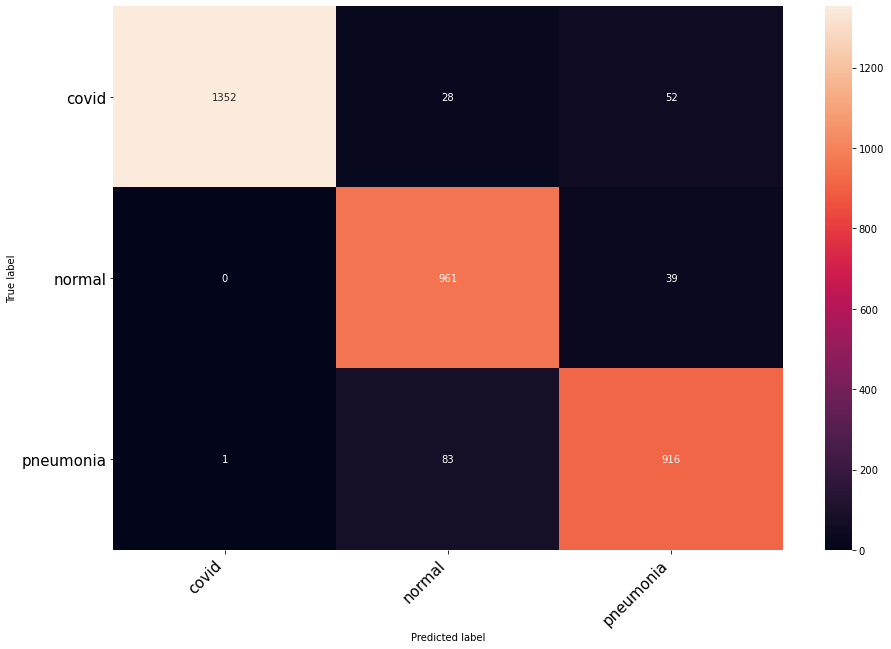

In [29]:
plt.figure(figsize=(15,10))

class_names = validloader.dataset.classes
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("/media/brats/DRIVE1/akansh/DeepXrays/Figures/baseline_resnet50_100epochs.png")